# Spherical Splines based on Jupp & Kent (1987)

This notebook implements the algorithm for fitting splines introdiced in [Fitting Smooth Paths to Spherical Data](https://www.jstor.org/stable/2347843). The same implements a series of projections of spherical data to the 2D plane and then applies splines fit there. 

In [1]:
import pandas as pd
import numpy as np
import os
import cartopy.crs as ccrs
import pmagpy.ipmag as ipmag

from scipy.spatial.transform import Rotation as rotation
from scipy.optimize import minimize
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import CubicSpline

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns


plt.rcParams["figure.figsize"] = (15, 20)

from utils.spherical_splines import *

In [2]:
%load_ext autoreload
%autoreload 2

In this notebook, we are going to consider the following three examples:
1. Fake noiseless poles on the sphere. 
1. Aparent Polar Wander Path of Antarctica used in [Fitting Smooth Paths to Spherical Data (1987)](https://www.jstor.org/stable/2347843)
1. Aparent Polar Wander Path of Gondawana (Figure 11 in [Phanerozoic polar wander, palaeogeography and dynamics (2012)](https://www.sciencedirect.com/science/article/abs/pii/S0012825212000797))

## Example No1: Synthetic poles

In [10]:
np.linspace(0,100, 50)

array([  0.               ,   2.040816326530612,   4.081632653061225,
         6.122448979591837,   8.16326530612245 ,  10.204081632653061,
        12.244897959183675,  14.285714285714286,  16.3265306122449  ,
        18.367346938775512,  20.408163265306122,  22.448979591836736,
        24.48979591836735 ,  26.53061224489796 ,  28.571428571428573,
        30.612244897959183,  32.6530612244898  ,  34.69387755102041 ,
        36.734693877551024,  38.775510204081634,  40.816326530612244,
        42.85714285714286 ,  44.89795918367347 ,  46.93877551020408 ,
        48.9795918367347  ,  51.02040816326531 ,  53.06122448979592 ,
        55.10204081632653 ,  57.142857142857146,  59.183673469387756,
        61.224489795918366,  63.26530612244898 ,  65.3061224489796  ,
        67.34693877551021 ,  69.38775510204081 ,  71.42857142857143 ,
        73.46938775510205 ,  75.51020408163265 ,  77.55102040816327 ,
        79.59183673469389 ,  81.63265306122449 ,  83.6734693877551  ,
        85.714285714

In [54]:
df = pd.DataFrame.from_dict({'Time': np.linspace(0,100,51)})
df['Lat'] = 90 - df['Time'] * 0.5
df['Lon'] = df['Time'] * 1.5 

# Add cartesian coordinates
df['x'] = df.apply(lambda row: sph2cart([np.radians(row["Lat"]), np.radians(row.Lon)])[0], axis=1) 
df['y'] = df.apply(lambda row: sph2cart([np.radians(row["Lat"]), np.radians(row.Lon)])[1], axis=1) 
df['z'] = df.apply(lambda row: sph2cart([np.radians(row["Lat"]), np.radians(row.Lon)])[2], axis=1) 

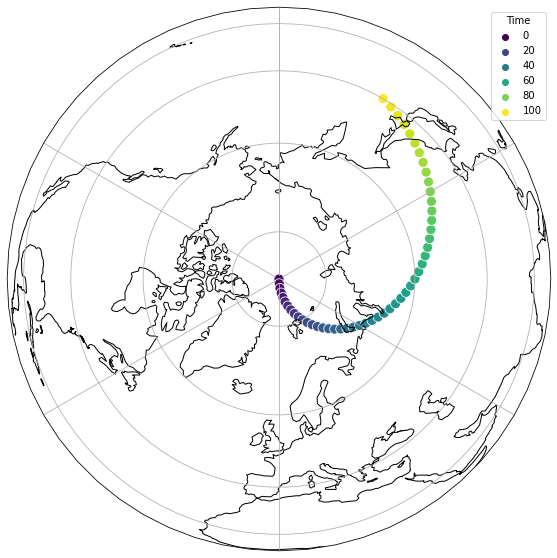

In [18]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.Orthographic(central_latitude=90))

ax.coastlines()
ax.gridlines()
ax.set_global()

sns.scatterplot(ax=ax, x = df['Lon'], y = df['Lat'], 
                hue = df['Time'], s=100,
                palette="viridis",
                transform = ccrs.PlateCarree());

We can try different smoothing parameters and see how they perform. The smoothing parameter `smoothing` inside the function `spherical_spline` quantifies the level of smoothing we want to impose in the curve. Smaller values correspond to more smooth curves. 

We can customize most of the parameters inside `spherical_splines`, but except `smoothing` which must be selected by the user, the other values can be set using the default option. 

In [19]:
help(spherical_spline)

Help on function spherical_spline in module utils.spherical_splines:

spherical_spline(times, knot_values, smoothing, precision=0.1, ode_stepsize=0.01, n_iter=5, tol=0.001, weights=None, fix_origin=True, reference_hemisphere='North')
    Constructs a smooth fitiing on points in the sphere based on the methods introduced 
    in Jupp et. al. (1987). This function executes the rolling and unrolling of points from 
    the sphere to the 2D plane and fits spline in the plane. 
    
    Parameters
    ----------
    times : array_like, (N,)
        Time series associated with the points in the sphere.
    knot_values: 2D array_like, (N,3)
        Cartesian cordinates of the points to fit. These points must be restricted to 
        lie in the sphere
    smoothing: float between 0 and 1. 
        Smoothing parameter used in the 2D splines method. Lower values correspond to more 
        smoothing, while larger value will weight more the data over the smoothing. For more 
        information,

In [21]:
%%time

log_smoothings = np.linspace(-4, -1, 10)
smoothings = 10 ** log_smoothings

all_curves = {}

for s in smoothings:
    
    print("Running smoothing = ", s)
    
    final_curve = spherical_spline(times=df.Time.values,
                                   knot_values=df[['x','y','z']].values,
                                   smoothing=s)
    all_curves[s] = final_curve

Running smoothing =  0.0001
Maximul tolerance reached after a total of 5 iterations.
Running smoothing =  0.00021544346900318845
Maximul tolerance reached after a total of 5 iterations.
Running smoothing =  0.00046415888336127773
Maximul tolerance reached after a total of 5 iterations.
Running smoothing =  0.001
Maximul tolerance reached after a total of 5 iterations.
Running smoothing =  0.002154434690031882
Maximul tolerance reached after a total of 5 iterations.
Running smoothing =  0.004641588833612777
Maximul tolerance reached after a total of 5 iterations.
Running smoothing =  0.01
Maximul tolerance reached after a total of 5 iterations.
Running smoothing =  0.021544346900318822
Maximul tolerance reached after a total of 5 iterations.
Running smoothing =  0.046415888336127774
Maximul tolerance reached after a total of 5 iterations.
Running smoothing =  0.1
Maximul tolerance reached after a total of 5 iterations.
CPU times: user 1min 23s, sys: 136 ms, total: 1min 23s
Wall time: 1m

Now, we can see that for many different values of the smoothing coefficient, the splines coincides with the colection of fake points. 

Smooth:  0.004641588833612777


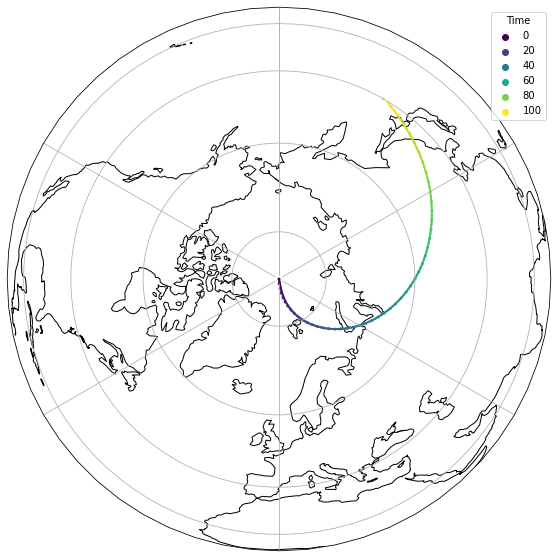

In [25]:
all_keys = list(all_curves.keys())
idx = 5
s = all_keys[idx]
print('Smooth: ', s)

time_values, knot_values = all_curves[s]

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.Orthographic(central_latitude=90))

ax.coastlines()
ax.gridlines()
ax.set_global()

knot_values_sph = cart2sph(knot_values, radians=False)[1::10,:]
times = time_values[1::10]

cmap = mpl.cm.get_cmap('viridis')
norm = mpl.colors.Normalize(time_values.min(), time_values.max())

for i in range(knot_values_sph.shape[0]-1):
    plt.plot([knot_values_sph[i,0], knot_values_sph[i+1,0]], 
             [knot_values_sph[i,1], knot_values_sph[i+1,1]],
             linewidth=2, color=cmap(norm(times[i])),
             transform = ccrs.Geodetic())


sns.scatterplot(ax=ax, x = df['Lon'], y = df['Lat'], 
                hue = df['Time'], s=10,
                palette="viridis",
                transform = ccrs.PlateCarree());

## Example No2: Aparent Polar Wander Path of Antarctica

This example is the same one used in the original paper [Fitting Smooth Paths to Spherical Data](https://www.jstor.org/stable/2347843).

In [26]:
df = pd.read_csv('data/Jupp-etal-1987_dataset.csv', encoding="cp1254")

# In order to do splines, we need the time coordinate to be strictly increasing. This is a little bit annoying, so for now
# we replace poles with same age by picking the first one in the age
df = df.groupby(['Time']).first().reset_index()

# Add cartesian coordinates
df['x'] = df.apply(lambda row: sph2cart([np.radians(row["Lat"]), np.radians(row.Lon)])[0], axis=1) 
df['y'] = df.apply(lambda row: sph2cart([np.radians(row["Lat"]), np.radians(row.Lon)])[1], axis=1) 
df['z'] = df.apply(lambda row: sph2cart([np.radians(row["Lat"]), np.radians(row.Lon)])[2], axis=1) 

df = df.sort_values(by='Time')

df

,Time,ï»¿Obs,Lat,Lon,x,y,z
0,0.3,A,80.6,349.2,0.160433,-0.030604,0.986572
1,1.0,B,86.2,123.7,-0.036772,0.055137,0.997801
2,14.9,D,83.3,294.0,0.047454,-0.106584,0.993171
3,26.6,E,84.8,67.6,0.034537,0.083794,0.995884
4,32.5,F,81.0,41.0,0.118063,0.102630,0.987688
5,55.5,G,86.0,178.0,-0.069714,0.002434,0.997564
6,68.9,H,76.0,147.0,-0.202893,0.131760,0.970296
7,98.0,I,86.0,298.0,0.032749,-0.061591,0.997564
8,106.0,J,70.8,15.4,0.317059,0.087333,0.944376
9,107.8,K,61.5,244.2,-0.207674,-0.429595,0.878817


In [48]:
%%time

final_curve = spherical_spline(times=df.Time.values,
                               knot_values=df[['x','y','z']].values,
                               smoothing=2.5e-5)

Maximul tolerance reached after a total of 5 iterations.
CPU times: user 1min 11s, sys: 152 ms, total: 1min 12s
Wall time: 1min 11s


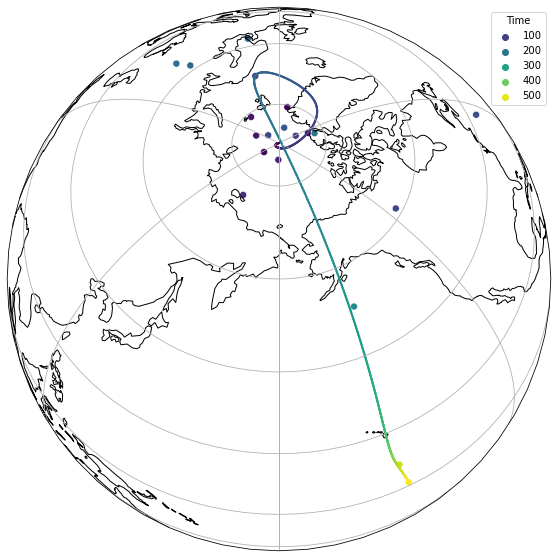

In [50]:
time_values, knot_values = final_curve

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.Orthographic(central_latitude=60, central_longitude=180))

ax.coastlines()
ax.gridlines()
ax.set_global()

knot_values_sph = cart2sph(knot_values, radians=False)[1::10,:]
times = time_values[1::10]

cmap = mpl.cm.get_cmap('viridis')
norm = mpl.colors.Normalize(time_values.min(), time_values.max())

for i in range(knot_values_sph.shape[0]-1):
    plt.plot([knot_values_sph[i,0], knot_values_sph[i+1,0]], 
             [knot_values_sph[i,1], knot_values_sph[i+1,1]],
             linewidth=2, color=cmap(norm(times[i])),
             transform = ccrs.Geodetic())


sns.scatterplot(ax=ax, x = df['Lon'], y = df['Lat'], 
                hue = df['Time'], s=50,
                palette="viridis",
                transform = ccrs.PlateCarree());

## Example No3: Aparent Polar Wander Path of Gondwana

For this example, we can use the South hemisphere as reference by setting `reference_hemisphere='South'`. Also, as the data became more noisy its a good idea to increase the precision parameters of the model. These precision parameters include:
- `precision`: precision at which the APWP is defined. Usually `0.1` is a good choice. 
- `ode_stepsize`: numerical stepsize of the differential equation solver used to unroll/roll points from/to the sphere. Smaller values are desirable, since this will lead to a reduction of the numerical error. 
- `n_iter`: number of iterations needed to convergence. Usually the method converges after a few iterations, but if more precision is desired this can be set a little bit larger. 

In [60]:
df = pd.read_csv('data/Torsvik-etal-2012_dataset.csv', encoding="cp1254")
df = df[df.Plate.isin(['Amazonia', 'Parana', 'Colorado', 'Southern_Africa', \
                       'East_Antarctica', 'Madagascar', 'Patagonia', 'Northeast_Africa', \
                       'Northwest_Africa', 'Somalia', 'Arabia'])]
df.RLat.fillna(df.Lat, inplace=True)
df.RLon.fillna(df.Lon, inplace=True)
df['Time'] = df['Age']
df['Lat'] = df['RLat']
df['Lon'] = df['RLon']
df = df.groupby(['Time']).first().reset_index()
df = df[['Time', "Lat", 'Lon', 'Q']]
    
# Add cartesian coordinates
df['x'] = df.apply(lambda row: sph2cart([np.radians(row["Lat"]), np.radians(row.Lon)])[0], axis=1) 
df['y'] = df.apply(lambda row: sph2cart([np.radians(row["Lat"]), np.radians(row.Lon)])[1], axis=1) 
df['z'] = df.apply(lambda row: sph2cart([np.radians(row["Lat"]), np.radians(row.Lon)])[2], axis=1) 

df = df.sort_values(by='Time')
df

,Time,Lat,Lon,Q,x,y,z
0,1.0,-87.5,-2.3,3,0.043584,-0.001751,-0.999048
1,1.5,-87.6,346.9,5,0.040786,-0.009491,-0.999123
2,2.0,-87.3,34.3,3,0.038915,0.026546,-0.998890
3,2.5,-79.6,-11.0,3,0.177203,-0.034445,-0.983571
4,3.0,-84.9,127.9,5,-0.054606,0.070145,-0.996041
...,...,...,...,...,...,...,...
117,510.0,24.1,12.1,3,0.892554,0.191347,0.408330
118,515.0,9.5,6.1,3,0.980701,0.104807,0.165048
119,521.0,1.6,-10.7,4,0.982230,-0.185594,0.027922
120,522.0,27.8,-15.9,5,0.850738,-0.242339,0.466387


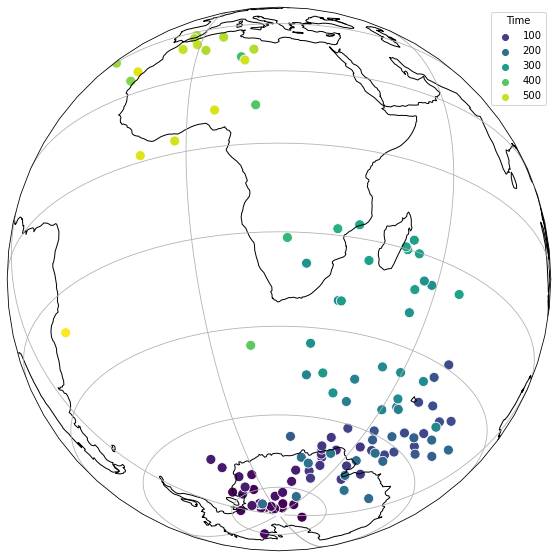

In [61]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.Orthographic(central_latitude=-30, central_longitude=20))

ax.coastlines()
ax.gridlines()
ax.set_global()

sns.scatterplot(ax=ax, x = df['Lon'], y = df['Lat'], 
                hue = df['Time'], s=100,
                palette="viridis",
                transform = ccrs.PlateCarree());

In [53]:
%%time

final_curve = spherical_spline(times=df.Time.values,
                               knot_values=df[['x','y','z']].values,
                               smoothing=0.0002,
                               precision=0.1,
                               ode_stepsize=0.002,   
                               n_iter=10,
                               weights=df.Q.values,
                               fix_origin=True, 
                               reference_hemisphere='South')

Maximul tolerance reached after a total of 10 iterations.
CPU times: user 7min 10s, sys: 219 ms, total: 7min 10s
Wall time: 7min 10s


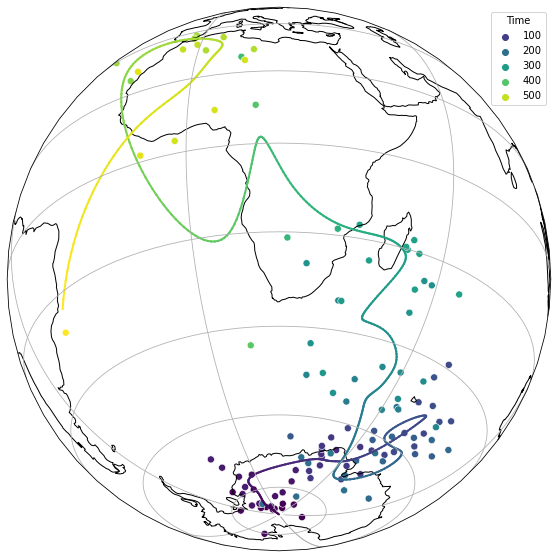

In [62]:
time_values, knot_values = final_curve

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.Orthographic(central_latitude=-30, central_longitude=20))

ax.coastlines()
ax.gridlines()
ax.set_global()

knot_values_sph = cart2sph(knot_values, radians=False)[1::10,:]
times = time_values[1::10]

cmap = mpl.cm.get_cmap('viridis')
norm = mpl.colors.Normalize(time_values.min(), time_values.max())

for i in range(knot_values_sph.shape[0]-1):
    plt.plot([knot_values_sph[i,0], knot_values_sph[i+1,0]], 
             [knot_values_sph[i,1], knot_values_sph[i+1,1]],
             linewidth=2, color=cmap(norm(times[i])),
             transform = ccrs.Geodetic())


sns.scatterplot(ax=ax, x = df['Lon'], y = df['Lat'], 
                hue = df['Time'], s=50,
                palette="viridis",
                transform = ccrs.PlateCarree());